In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
from sklearn.pipeline import Pipeline
sys.path.append('/home/lolo/Desktop/dnnComm/vde/vde/')
from vde import VDE 

name= '/home/lolo/Desktop/dnnComm/RML2016.10a_dict.pkl'
data = pd.read_pickle(name)

In [2]:
list = []
for d in data:
    list.append(d)    

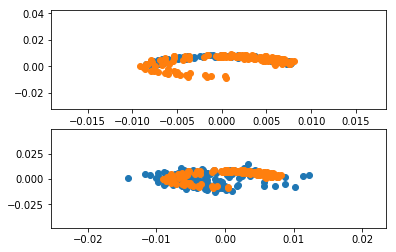

In [3]:
#print (list[0])
dp0 = data[list[35]]
dp1 = data[list[25]]
dp2 = data[list[14]]
plt.figure()
plt.subplot(2,1,1); plt.scatter(dp0[1, 0,:], dp0[1, 1,:]); plt.scatter(dp2[1, 0,:], dp2[1, 1,:]); 
plt.subplot(2,1,2); plt.scatter(dp1[1, 0,:], dp1[1, 1,:]); plt.scatter(dp2[1, 0,:], dp2[1, 1,:]);
plt.show()
#print(data[list[0]].shape, len(list))

In [4]:
print (list)

[('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('AM-SSB', 12), ('8PSK', 8), ('8PSK', 12), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('PAM4', -6), ('WBFM', -18), ('AM-DSB', 16), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('AM-SSB', 6), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('AM-SSB', -12), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('BPSK', -10), ('QPSK', 8), ('PAM4', 14), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('WBFM', -4), ('AM-SSB', -18), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('8PSK', -8), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('AM-SSB', 8), ('GFSK', 18), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('AM-SSB', -2), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('AM-SSB', 2), ('WBFM', 10), ('AM-DSB', -12), ('PAM4', 4), ('G

In [13]:
trajs = []
stride = 20
for l in range(len(list)):
    d = data[list[l]]
    for i in range(0, len(d), stride):
        trajs.append(d[i, :, :].T)
#print (trajs[100])    
print (len(trajs))

11000


In [14]:
lag_time = 10
mdl = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=50, n_epochs=2, cuda=False, 
          sliding_window=True, dropout_rate=0.3,
          learning_rate=1E-3)

In [ ]:
mdl.fit(trajs)

Epoch: 0
Batch 100, loss = 1.3647
rec_loss = 0.2047, autocorr_loss = 1.1599
Batch 200, loss = 1.2435
rec_loss = 0.1401, autocorr_loss = 1.1034
Batch 300, loss = 1.1479
rec_loss = 0.1076, autocorr_loss = 1.0403
Batch 400, loss = 1.0692
rec_loss = 0.0823, autocorr_loss = 0.9869
Batch 500, loss = 0.9792
rec_loss = 0.0605, autocorr_loss = 0.9186
Batch 600, loss = 1.2538
rec_loss = 0.0288, autocorr_loss = 1.2250
Batch 700, loss = 0.9622
rec_loss = 0.0280, autocorr_loss = 0.9342
Batch 800, loss = 0.9711
rec_loss = 0.0329, autocorr_loss = 0.9382
Batch 900, loss = 1.1638
rec_loss = 0.0348, autocorr_loss = 1.1291
Batch 1000, loss = 0.6741
rec_loss = 0.0186, autocorr_loss = 0.6555
Batch 1100, loss = 1.0100
rec_loss = 0.0326, autocorr_loss = 0.9774
Batch 1200, loss = 1.0053
rec_loss = 0.0209, autocorr_loss = 0.9845
Batch 1300, loss = 1.0651
rec_loss = 0.0285, autocorr_loss = 1.0366
Batch 1400, loss = 0.9306
rec_loss = 0.0265, autocorr_loss = 0.9040
Batch 1500, loss = 0.9437
rec_loss = 0.0233, aut

In [11]:
def scatter(decomposition, cmap='plasma', stride=1, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs)[::stride].T, c=cmap(w), s=1)

    return ax

def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

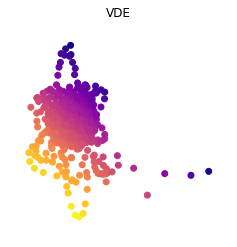

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))

scatter(mdl, cmap='plasma_r', ax=ax1)
ax1.set_title('VDE')
clean_up(ax1)